# ERPs Analysis
In this notebook, we take the MATLAB files containing each subject's trials ERPs average per category. We analyse it to find the differences in hiher and lower peak latency across categories after stimulus onset.

### 1. Load data

In [170]:
from os.path import dirname, join as pjoin
import scipy.io as sio
from operator import itemgetter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import argrelextrema

import pandas as pd
import pyxdf
#import dataframe_image as dfi
import seaborn as sns

In [172]:
data_path  = "data/erps"
erps_file = pjoin(data_path, "mean_activation_all_8_sub_PO8.mat")
erps_content = sio.loadmat(erps_file)

In [173]:
ch_keys = ["erps_body", "erps_face", "erps_object"]
all_keys = ch_keys.copy()
all_keys.append("subj_time")
df = pd.DataFrame(columns=np.concatenate([all_keys]))

# Extract data for each participant, as many as there are time series
participant_count = len(dict(erps_content)["subj_time"])
for participant in range(participant_count):
    df_participant = pd.DataFrame()
    # Extract all keys into dataframe columns
    for key in all_keys:
        series_array = dict(erps_content)[key]
        df_participant[key] = pd.Series(series_array[participant])
    df_participant['subject'] = participant

    # Add full participant extraction to final dataframe
    df = pd.concat([df, df_participant], ignore_index=True)

df

erps_body  erps_face  erps_object   subj_time  subject
0      5.915901   6.110841     5.858163 -199.218750      0.0
1      6.088581   6.456994     6.140627 -197.265625      0.0
2      6.139641   6.606117     6.448425 -195.312500      0.0
3      6.593696   6.790761     6.460158 -193.359375      0.0
4      6.589998   7.117500     6.645327 -191.406250      0.0
...         ...        ...          ...         ...      ...
2859   5.010485   5.210922     4.485417  490.234375      7.0
2860   5.001881   5.355083     4.451282  492.187500      7.0
2861   5.043113   5.256223     4.632553  494.140625      7.0
2862   5.057186   5.056796     4.908361  496.093750      7.0
2863   4.741613   5.175090     4.924191  498.046875      7.0

[2864 rows x 5 columns]

In [174]:
# df2 = df[["erps_body","erps_face","erps_object","subj_time"]]
# by melting the df this way, I can easy plot the 'variable' columns that contains all categories
df2 = df.melt(id_vars=["subj_time","subject"])
df2

subj_time  subject     variable     value
0    -199.218750      0.0    erps_body  5.915901
1    -197.265625      0.0    erps_body  6.088581
2    -195.312500      0.0    erps_body  6.139641
3    -193.359375      0.0    erps_body  6.593696
4    -191.406250      0.0    erps_body  6.589998
...          ...      ...          ...       ...
8587  490.234375      7.0  erps_object  4.485417
8588  492.187500      7.0  erps_object  4.451282
8589  494.140625      7.0  erps_object  4.632553
8590  496.093750      7.0  erps_object  4.908361
8591  498.046875      7.0  erps_object  4.924191

[8592 rows x 4 columns]

<AxesSubplot:xlabel='subj_time', ylabel='value'>

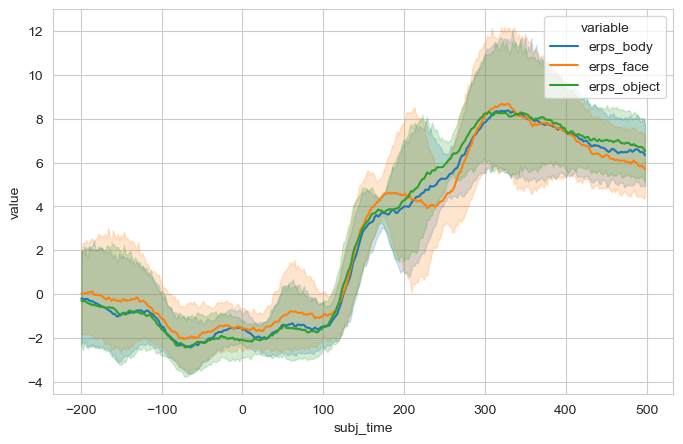

In [175]:
fig, ax = plt.subplots(nrows=1, figsize=(8, 5))
# time_window = df.loc[df['subject'] == 1, 'sub_time']
# time_window
sns.lineplot(data= df2, x='subj_time', y='value', hue='variable')
# sns.lineplot(data= df, x='subj_time', y='erps_object')

### 2. Create time windows to calculate max and min peak

In [176]:
n = 10  # number of points to be checked before and after
find_gradient_extrema_start_time = 0 # start to look for gradient extrema
find_gradient_extrema_end_time = 200

# Clean up old dataframe before making a copy
if 'df3' in locals():
    del df3
df3 = df

# Calculate local maxima and minima
for key in ch_keys:
    df3[key+'_min'] = df3.iloc[argrelextrema(df3[key].values, np.less_equal, order=n)[0]][key]
    df3[key+'_max'] = df3.iloc[argrelextrema(df3[key].values, np.greater_equal, order=n)[0]][key]

    # Calculate gradients, i.e., slops of the data; hypotheis: first stepest upwards gradient is where the time window for the max / min should be looked for
    df3[key+'_grads'] = np.gradient(df3[key])
    grads_extrema = []
    for participant in range(participant_count):
        df3_part = df3[(df3['subject'] == participant) & # select particpant
                       (df3['subj_time'] > find_gradient_extrema_start_time) & # select start time to find gradient extrema
                       (df3['subj_time'] <= find_gradient_extrema_end_time)] # select end time to find graident extrema
        df3_part[key+'_grads'] = np.gradient(df3_part[key])
        # Find extrema (min max) per participant
        grads_extrema.append(df3_part[key+"_grads"].idxmin())
        grads_extrema.append(df3_part[key+"_grads"].idxmax())

    # Store all gradient extrema back into the pandas dataframe
    df3[key+'_grads_extrema'] = df3.iloc[np.array(grads_extrema)][key+"_grads"]
    df3[key+'_grads_extrema_key_value'] = df3.loc[df3[key+'_grads_extrema'].notna()][key]

df3

/var/folders/yy/s3wgmwl10fg_cc7cb_s92snr0000gn/T/ipykernel_40610/3594414112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_part[key+'_grads'] = np.gradient(df3_part[key])


erps_body  erps_face  erps_object   subj_time  subject  erps_body_min  \
0      5.915901   6.110841     5.858163 -199.218750      0.0       5.915901   
1      6.088581   6.456994     6.140627 -197.265625      0.0            NaN   
2      6.139641   6.606117     6.448425 -195.312500      0.0            NaN   
3      6.593696   6.790761     6.460158 -193.359375      0.0            NaN   
4      6.589998   7.117500     6.645327 -191.406250      0.0            NaN   
...         ...        ...          ...         ...      ...            ...   
2859   5.010485   5.210922     4.485417  490.234375      7.0            NaN   
2860   5.001881   5.355083     4.451282  492.187500      7.0            NaN   
2861   5.043113   5.256223     4.632553  494.140625      7.0            NaN   
2862   5.057186   5.056796     4.908361  496.093750      7.0            NaN   
2863   4.741613   5.175090     4.924191  498.046875      7.0       4.741613   

      erps_body_max  erps_body_grads  erps_body_grads_extrema  \
0               NaN         0.172680                      NaN   
1               NaN         0.111870                      NaN   
2               NaN         0.252557                      NaN   
3               NaN         0.225179                      NaN   
4               NaN         0.072983                      NaN   
...             ...              ...                      ...   
2859            NaN        -0.024598                      NaN   
2860            NaN         0.016314                      NaN   
2861            NaN         0.027653                      NaN   
2862            NaN        -0.150750                      NaN   
2863            NaN        -0.315573                      NaN   

      erps_body_grads_extrema_key_value  erps_face_min  erps_face_max  \
0                                   NaN       6.110841            NaN   
1                                   NaN            NaN            NaN   
2                                   NaN            NaN            NaN   
3                                   NaN            NaN            NaN   
4                                   NaN            NaN            NaN   
...                                 ...            ...            ...   
2859                                NaN            NaN            NaN   
2860                                NaN            NaN       5.355083   
2861                                NaN            NaN            NaN   
2862                                NaN            NaN            NaN   
2863                                NaN            NaN            NaN   

      erps_face_grads  erps_face_grads_extrema  \
0            0.346153                      NaN   
1            0.247638                      NaN   
2            0.166883                      NaN   
3            0.255691                      NaN   
4            0.212455                      NaN   
...               ...                      ...   
2859         0.050127                      NaN   
2860         0.022650                      NaN   
2861        -0.149143                      NaN   
2862        -0.040566                      NaN   
2863         0.118295                      NaN   

      erps_face_grads_extrema_key_value  erps_object_min  erps_object_max  \
0                                   NaN         5.858163              NaN   
1                                   NaN              NaN              NaN   
2                                   NaN              NaN              NaN   
3                                   NaN              NaN              NaN   
4                                   NaN              NaN              NaN   
...                                 ...              ...              ...   
2859                                NaN              NaN              NaN   
2860                                NaN         4.451282              NaN   
2861                                NaN              NaN              NaN   
2862                        

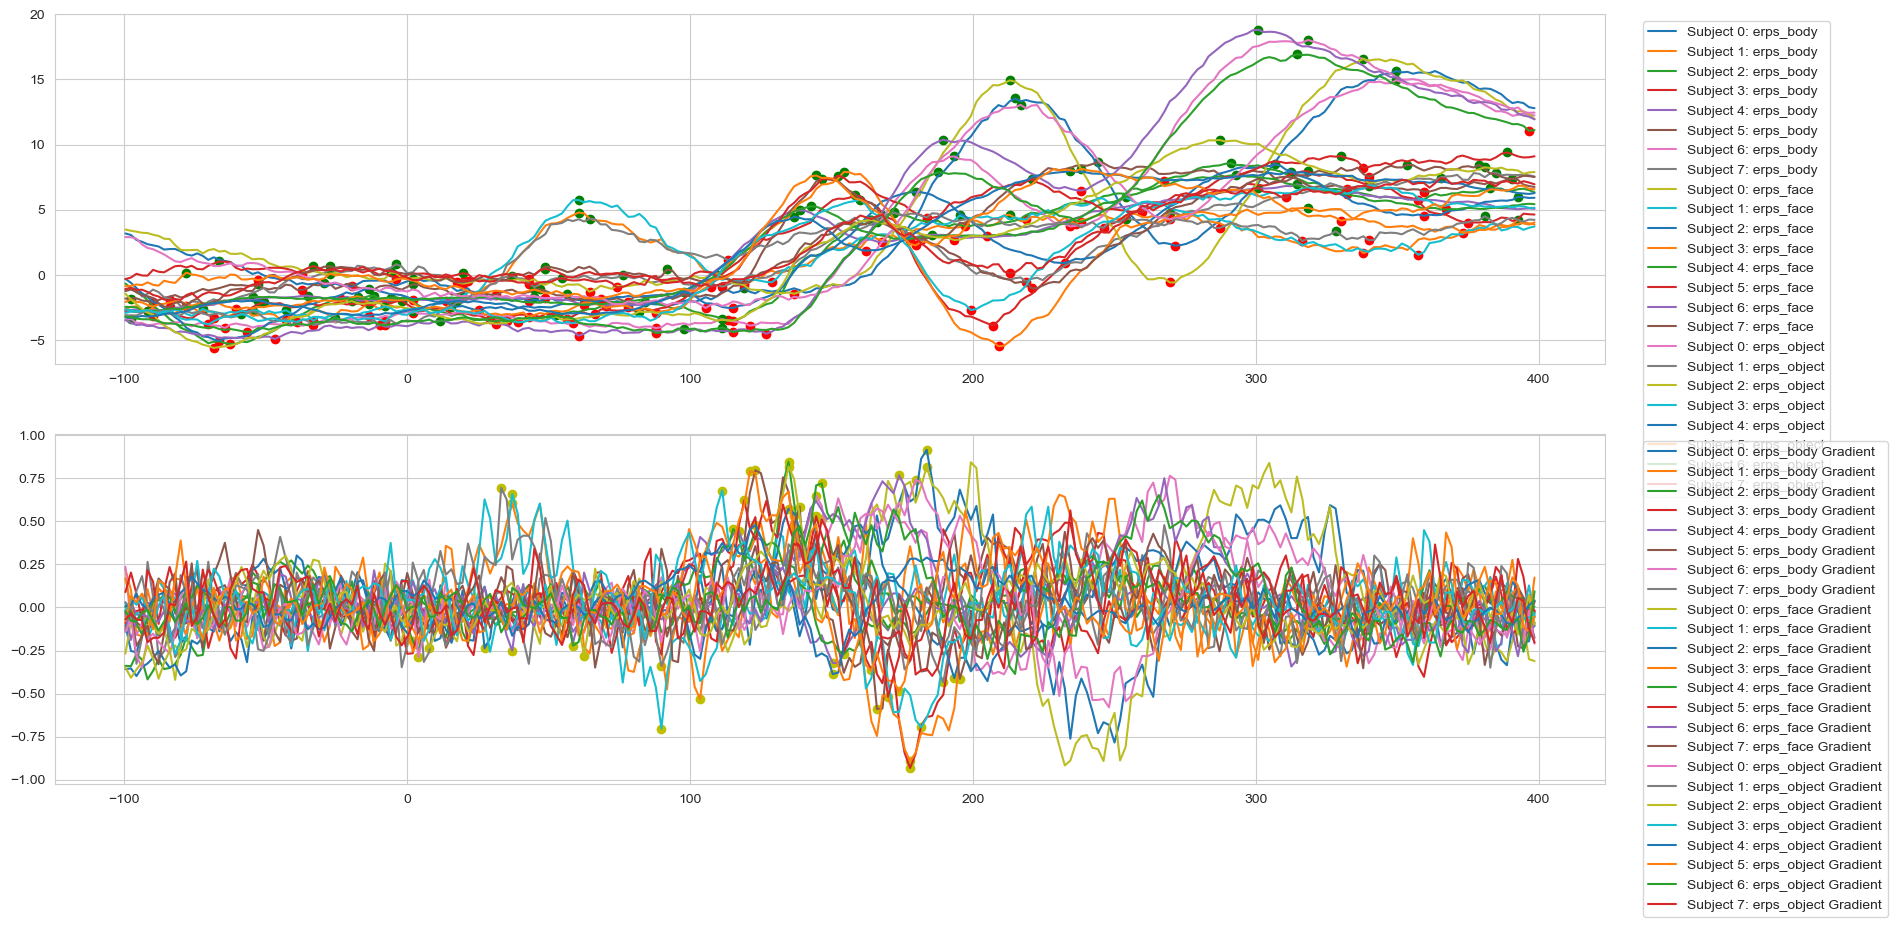

In [177]:
# Plot results
global_time_window_start = -100
global_time_window_end = 400

fig, ax = plt.subplots(figsize=(20,10), ncols=1, nrows=2)

for key in ch_keys:
    for participant in range(participant_count):
        df4 = df3[df3['subject'] == participant] # select participant
        df4 = df4[(df4['subj_time'] > global_time_window_start) & (df4['subj_time'] < global_time_window_end)] # select time window
        ax[0].scatter(df4.subj_time, df4[key+'_min'], c='r')
        ax[0].scatter(df4.subj_time, df4[key+'_max'], c='g')
        line, = ax[0].plot(df4.subj_time, df4[key])
        line.set_label(f"Subject {participant}: {key}")
        ax[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

        # # Also print gradients and their extrema
        ax[1].scatter(df4.subj_time, df4[key+'_grads_extrema'], c='y')
        line, = ax[1].plot(df4.subj_time, df4[key+'_grads'])
        line.set_label(f"Subject {participant}: {key} Gradient")
        ax[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

plt.show()

### 3. Find individual peaks
Find maximum positive and negative peaks per subject

Subject 0, key erps_body has minimum 2.2399916648864746 and maximum 13.544217109680176, difference is 11.304225444793701
Subject 0, key erps_face has minimum -0.5760124325752258 and maximum 14.922928810119629, difference is 15.498941242694855
Subject 0, key erps_object has minimum 4.273242473602295 and maximum 13.051939964294434, difference is 8.778697490692139


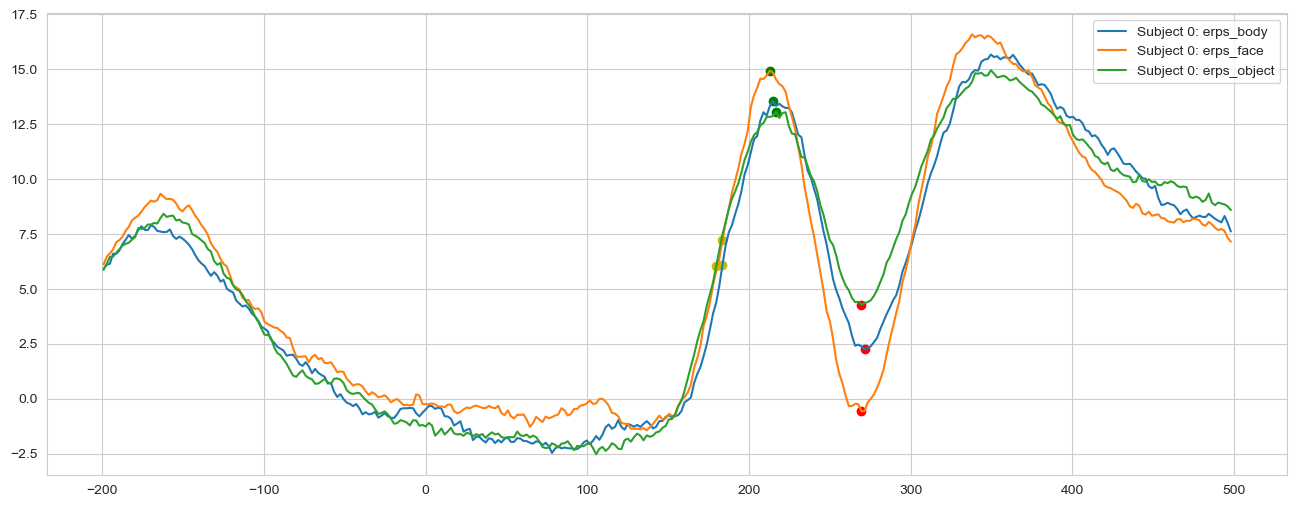

Subject 1, key erps_body has minimum -0.7455092668533325 and maximum 4.79033088684082, difference is 5.535840153694153
Subject 1, key erps_face has minimum -0.5618327260017395 and maximum 5.753466606140137, difference is 6.315299332141876
Subject 1, key erps_object has minimum 1.1412217617034912 and maximum 4.3072123527526855, difference is 3.1659905910491943


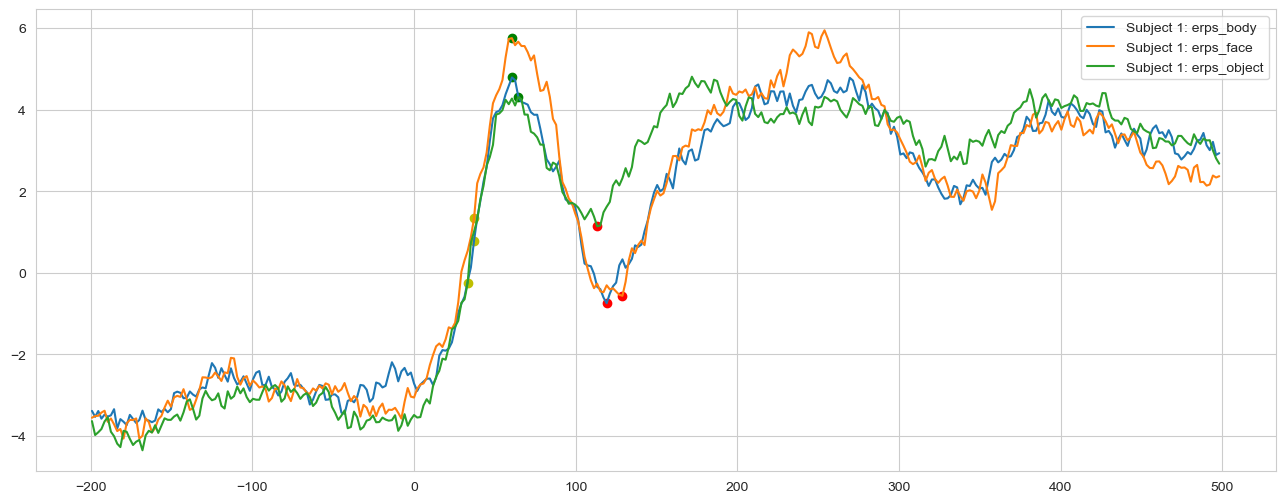

Subject 2, key erps_body has minimum 3.7351179122924805 and maximum 4.731099605560303, difference is 0.9959816932678223
Subject 2, key erps_face has minimum 0.9126566648483276 and maximum 6.3574323654174805, difference is 5.444775700569153
Subject 2, key erps_object has minimum 2.679304838180542 and maximum 4.229971885681152, difference is 1.5506670475006104


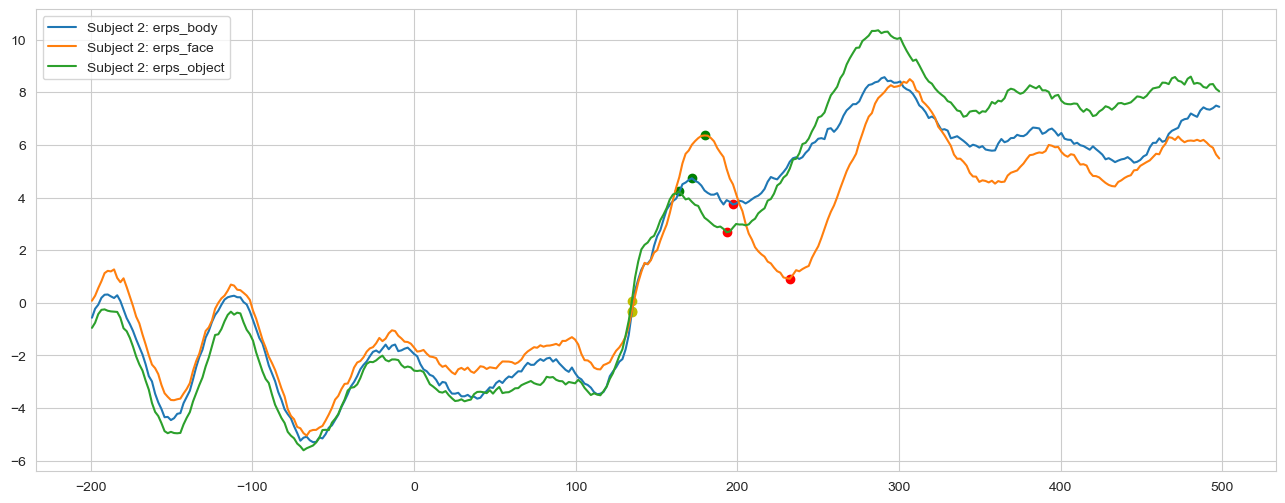

Subject 3, key erps_body has minimum -3.881314516067505 and maximum 6.104855537414551, difference is 9.986170053482056
Subject 3, key erps_face has minimum -5.477518558502197 and maximum 7.905889511108398, difference is 13.383408069610596
Subject 3, key erps_object has minimum -2.695131301879883 and maximum 5.770120143890381, difference is 8.465251445770264


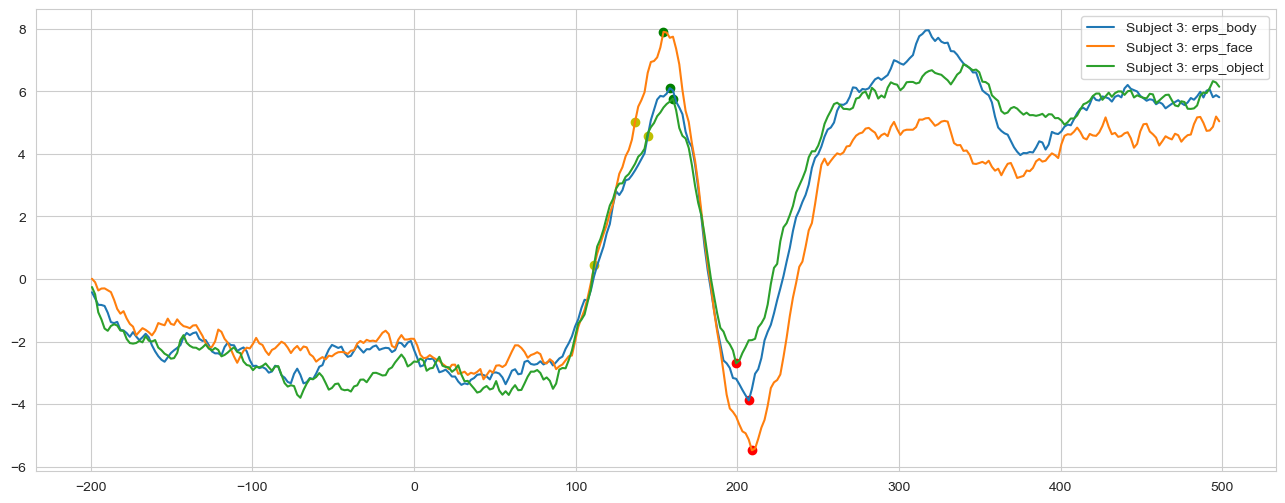

Subject 4, key erps_body has minimum 2.5199246406555176 and maximum 4.969473838806152, difference is 2.4495491981506348
Subject 4, key erps_face has minimum 2.738710641860962 and maximum 5.268340587615967, difference is 2.529629945755005
Subject 4, key erps_object has minimum 1.8611074686050415 and maximum 4.465773105621338, difference is 2.6046656370162964


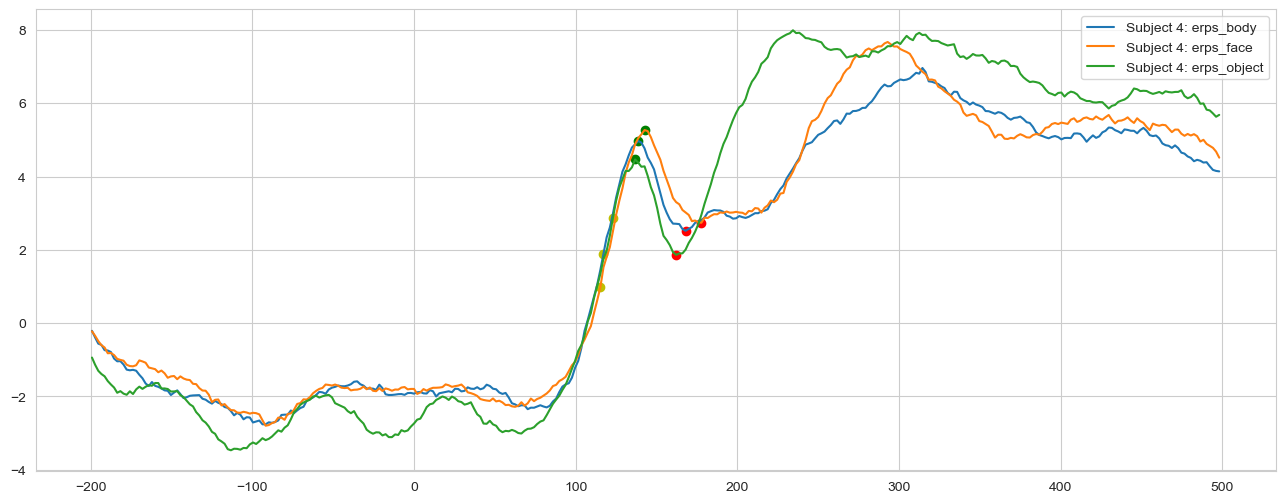

Subject 5, key erps_body has minimum 2.687896251678467 and maximum 7.39567756652832, difference is 4.7077813148498535
Subject 5, key erps_face has minimum 4.36458683013916 and maximum 7.625518798828125, difference is 3.260931968688965
Subject 5, key erps_object has minimum 2.267371416091919 and maximum 7.632042407989502, difference is 5.364670991897583


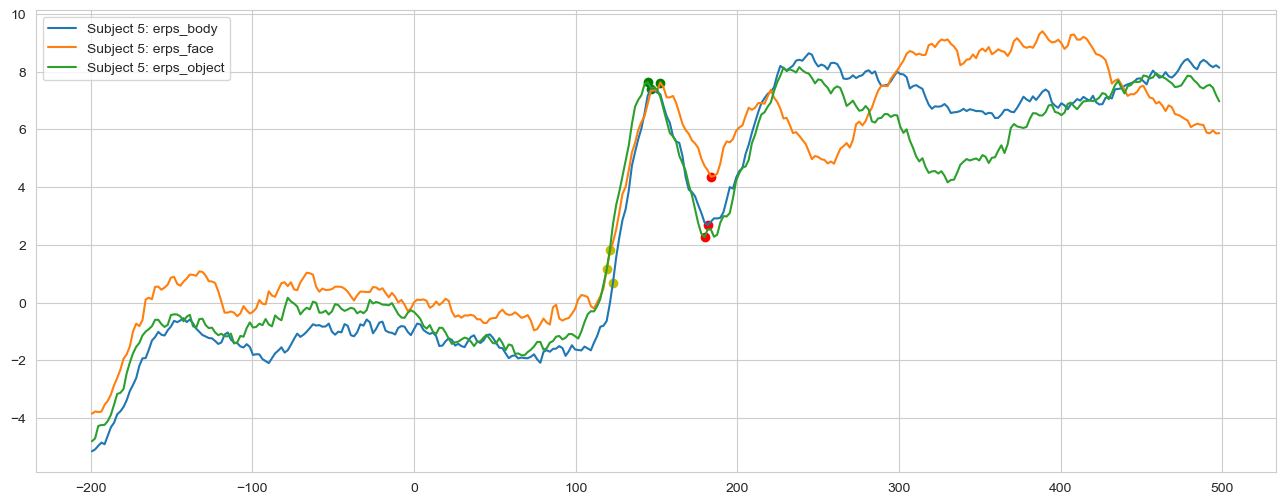

Subject 6, key erps_body has minimum 3.719270944595337 and maximum 9.096206665039062, difference is 5.376935720443726
Subject 6, key erps_face has minimum 6.47817325592041 and maximum 10.379767417907715, difference is 3.9015941619873047
Subject 6, key erps_object has minimum 4.071857452392578 and maximum 7.867554187774658, difference is 3.79569673538208


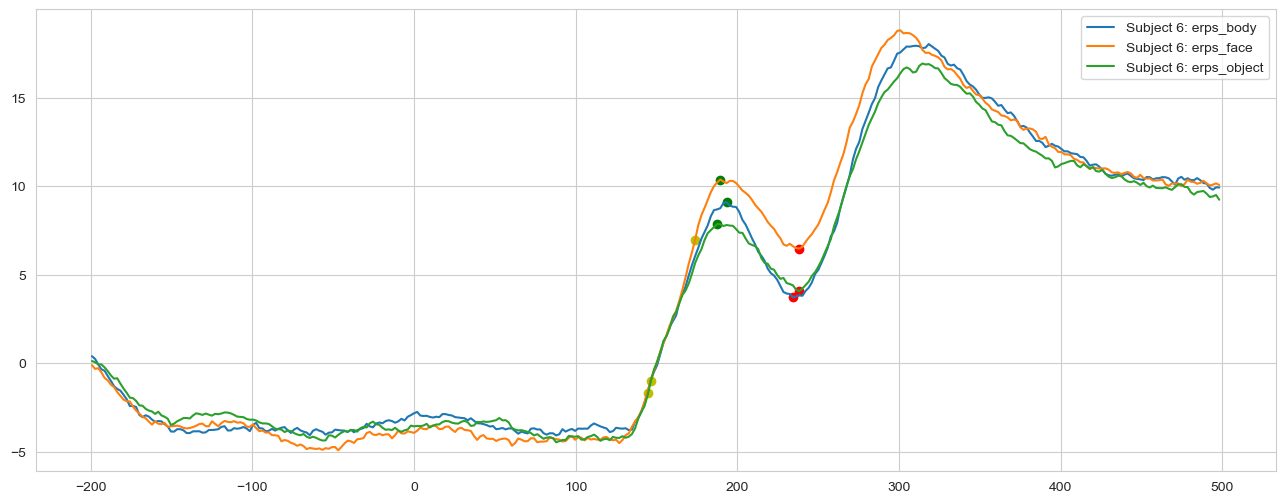

Subject 7, key erps_body has minimum -0.5057152509689331 and maximum 4.0622687339782715, difference is 4.567983984947205
Subject 7, key erps_face has minimum -1.0317906141281128 and maximum 4.2238006591796875, difference is 5.2555912733078
Subject 7, key erps_object has minimum 0.11607088893651962 and maximum 4.608160495758057, difference is 4.492089606821537


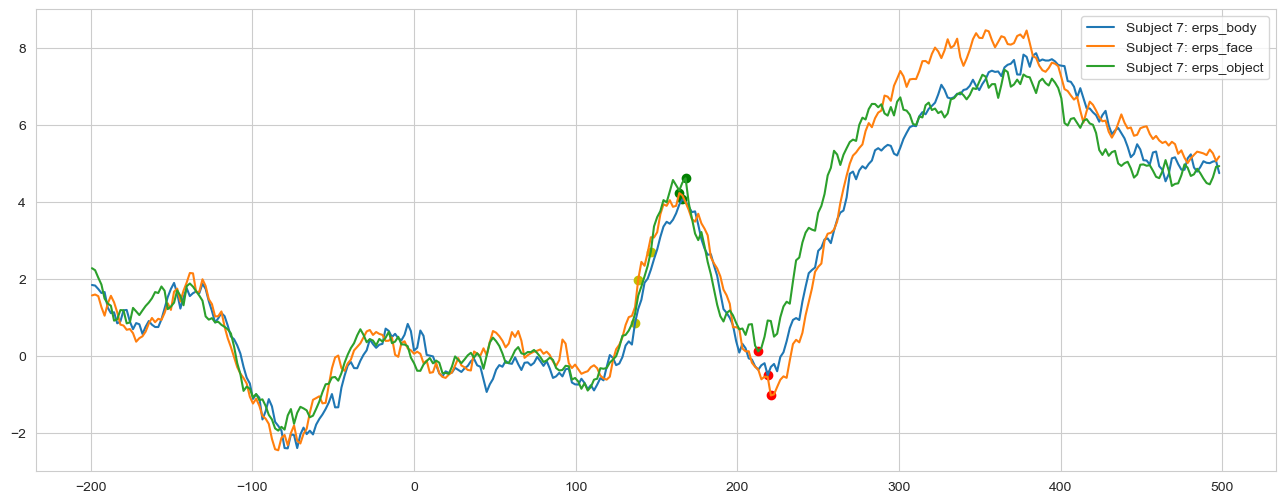

erps_body  erps_face  erps_object   subj_time  subject  erps_body_min  \
0      5.915901   6.110841     5.858163 -254.150391      0.0            NaN   
1      6.088581   6.456994     6.140627 -252.197266      0.0            NaN   
2      6.139641   6.606117     6.448425 -250.244141      0.0            NaN   
3      6.593696   6.790761     6.460158 -248.291016      0.0            NaN   
4      6.589998   7.117500     6.645327 -246.337891      0.0            NaN   
...         ...        ...          ...         ...      ...            ...   
2859   5.010485   5.210922     4.485417  476.969401      7.0            NaN   
2860   5.001881   5.355083     4.451282  478.922526      7.0            NaN   
2861   5.043113   5.256223     4.632553  480.875651      7.0            NaN   
2862   5.057186   5.056796     4.908361  482.828776      7.0            NaN   
2863   4.741613   5.175090     4.924191  484.781901      7.0            NaN   

      erps_body_max  erps_body_grads  erps_body_grads_extrema  \
0               NaN         0.172680                      NaN   
1               NaN         0.111870                      NaN   
2               NaN         0.252557                      NaN   
3               NaN         0.225179                      NaN   
4               NaN         0.072983                      NaN   
...             ...              ...                      ...   
2859            NaN        -0.024598                      NaN   
2860            NaN         0.016314                      NaN   
2861            NaN         0.027653                      NaN   
2862            NaN        -0.150750                      NaN   
2863            NaN        -0.315573                      NaN   

      erps_body_grads_extrema_key_value  erps_face_min  erps_face_max  \
0                                   NaN            NaN            NaN   
1                                   NaN            NaN            NaN   
2                                   NaN            NaN            NaN   
3                                   NaN            NaN            NaN   
4                                   NaN            NaN            NaN   
...                                 ...            ...            ...   
2859                                NaN            NaN            NaN   
2860                                NaN            NaN            NaN   
2861                                NaN            NaN            NaN   
2862                                NaN            NaN            NaN   
2863                                NaN            NaN            NaN   

      erps_face_grads  erps_face_grads_extrema  \
0            0.346153                      NaN   
1            0.247638                      NaN   
2            0.166883                      NaN   
3            0.255691                      NaN   
4            0.212455                      NaN   
...               ...                      ...   
2859         0.050127                      NaN   
2860         0.022650                      NaN   
2861        -0.149143                      NaN   
2862        -0.040566                      NaN   
2863         0.118295                      NaN   

      erps_face_grads_extrema_key_value  erps_object_min  erps_object_max  \
0                                   NaN              NaN              NaN   
1                                   NaN              NaN              NaN   
2                                   NaN              NaN              NaN   
3                                   NaN              NaN              NaN   
4                                   NaN              NaN              NaN   
...                                 ...              ...              ...   
2859                                NaN              NaN              NaN   
2860                                NaN              NaN              NaN   
2861                                NaN              NaN              NaN   
2862                        

subject          key       min        max       diff
0        0    erps_body  2.239992  13.544217  11.304225
1        0    erps_face -0.576012  14.922929  15.498941
2        0  erps_object  4.273242  13.051940   8.778697
3        1    erps_body -0.745509   4.790331   5.535840
4        1    erps_face -0.561833   5.753467   6.315299
5        1  erps_object  1.141222   4.307212   3.165991
6        2    erps_body  3.735118   4.731100   0.995982
7        2    erps_face  0.912657   6.357432   5.444776
8        2  erps_object  2.679305   4.229972   1.550667
9        3    erps_body -3.881315   6.104856   9.986170
10       3    erps_face -5.477519   7.905890  13.383408
11       3  erps_object -2.695131   5.770120   8.465251
12       4    erps_body  2.519925   4.969474   2.449549
13       4    erps_face  2.738711   5.268341   2.529630
14       4  erps_object  1.861107   4.465773   2.604666
15       5    erps_body  2.687896   7.395678   4.707781
16       5    erps_face  4.364587   7.625519   3.260932
17       5  erps_object  2.267371   7.632042   5.364671
18       6    erps_body  3.719271   9.096207   5.376936
19       6    erps_face  6.478173  10.379767   3.901594
20       6  erps_object  4.071857   7.867554   3.795697
21       7    erps_body -0.505715   4.062269   4.567984
22       7    erps_face -1.031791   4.223801   5.255591
23       7  erps_object  0.116071   4.608160   4.492090

diff
key                  
erps_body    5.615558
erps_face    6.948771
erps_object  4.777216

In [178]:
# Min / Max / Diff output dataframe
df_min_max = pd.DataFrame(columns=['subject', 'key', 'min', 'max', 'diff'])

# Cleaned output dataframe
if 'df_cleaned' in locals():
    del df_cleaned
df_cleaned = pd.DataFrame(columns=df3.columns)

# Dataframe to collect all signal onsets so that a time realignment at the end can be done
onset_all = pd.DataFrame()

for participant in range(participant_count):
    # Set up participant visualization
    plt.figure(figsize=(16,6))

    # Initiate participant cleaned dataframe
    df_participant_cleaned = df3[df3['subject'] == participant][['subject', 'subj_time']]

    ## Step 1: find the mean onset time for given participant (i.e., when gradient is steepest)
    df4 = df3[df3['subject'] == participant]
    df4.reset_index(inplace=True)

    # Get all participant's onset time stamp
    onset = pd.DataFrame()
    for key in ch_keys:
        onset = pd.concat([onset, df4.iloc[np.array([df4[key + '_grads_extrema'].idxmax()])]['subj_time']], ignore_index=True)

    onset_time_mean = onset.mean().loc[0] # use as the average subj_time time shift for this participant
    onset_time_min = onset.min().loc[0] # use as selection start time for cleaned data set and participant visualization
    onset_time_max = onset.max().loc[0] # use as selection end time for data cleaning and participant visualization (for onset points only)

    for key in ch_keys:
        ## Step 2: find the first min and max post the mean onset
        df4 = df3[(df3['subject'] == participant) &
                  (df3['subj_time'] >= onset_time_mean)]
        df4.reset_index(inplace=True)

        # Get participant first minima and maxima post the mean onset time
        max = df4.iloc[df4[key + '_max'].first_valid_index()][key + '_max']
        min = df4.iloc[df4[key + '_min'].first_valid_index()][key + '_min']

        # Set the end time of the local window, so we can use this to generate a clean, aligned dataset
        local_time_window_end = df4.iloc[np.array([df4[key + '_min'].first_valid_index()])]['subj_time'].iloc[0]

        ## Step 3: Add the min + max and diff to the resulting data frame
        print(f"Subject {participant}, key {key} has minimum {min} and maximum {max}, difference is {max-min}")
        d = {'subject': [participant], 'key': [key], 'min': [min], 'max': [max], 'diff': [max-min]}
        df_min_max = pd.concat([df_min_max, pd.DataFrame.from_dict(d)], ignore_index=True)

        ## Step 4: Assemble a clean dataframe
        # Part 1: add corrected time stamp, key and key gradient data
        df4 = df3[(df3['subject'] == participant)]
        df_participant_cleaned['subj_time'] = df4['subj_time'] - onset_time_mean
        df_participant_cleaned[key] = df4[key]
        df_participant_cleaned[key + '_grads'] = df4[key + '_grads']

        # Part 2: add key's min and max data only between onset time and local time window end
        df5 = df4[(df4['subj_time'] >= onset_time_min) &
                  (df4['subj_time'] <= local_time_window_end)]
        df_participant_cleaned[key + '_min'] = df5[key + '_min']
        df_participant_cleaned[key + '_max'] = df5[key + '_max']

        # Part 3: add key's onset gradient and value at that point (select only from within onset min to max range)
        df6 = df5[df5['subj_time'] <= onset_time_max]
        df_participant_cleaned[key + '_grads_extrema'] = df6[key + '_grads_extrema']
        df_participant_cleaned[key + '_grads_extrema_key_value'] = df6[key + '_grads_extrema_key_value']

        ## Step 5: Plot each participant data
        df4_points_min_max = df4[(df4['subj_time'] >= onset_time_min) & (df4['subj_time'] <= local_time_window_end)] # select time window
        plt.scatter(df4_points_min_max.subj_time, df4_points_min_max[key+'_min'], c='r')
        plt.scatter(df4_points_min_max.subj_time, df4_points_min_max[key+'_max'], c='g')
        df4_points_onset = df4[(df4['subj_time'] >= onset_time_min) & (df4['subj_time'] <= onset_time_max)] # select time window
        plt.scatter(df4_points_onset.subj_time, df4_points_onset[key+'_grads_extrema_key_value'], c='y')
        line, = plt.plot(df4.subj_time, df4[key])
        line.set_label(f"Subject {participant}: {key}")

    # Assemble cleaned data frame
    df_cleaned = pd.concat([df_cleaned, df_participant_cleaned], ignore_index=True)

    # Collect participant's onset points
    onset_all = pd.concat([onset_all, onset], ignore_index=True)

    # Visualize participant
    plt.legend()
    plt.show()

# Add mean onset back to regain time series alignment for cleaned data frame
df_cleaned['subj_time'] = df_cleaned['subj_time'].add(onset_all.mean().loc[0])

display(df_cleaned, df_min_max, df_min_max.groupby(['key']).agg({'diff': 'mean'}))

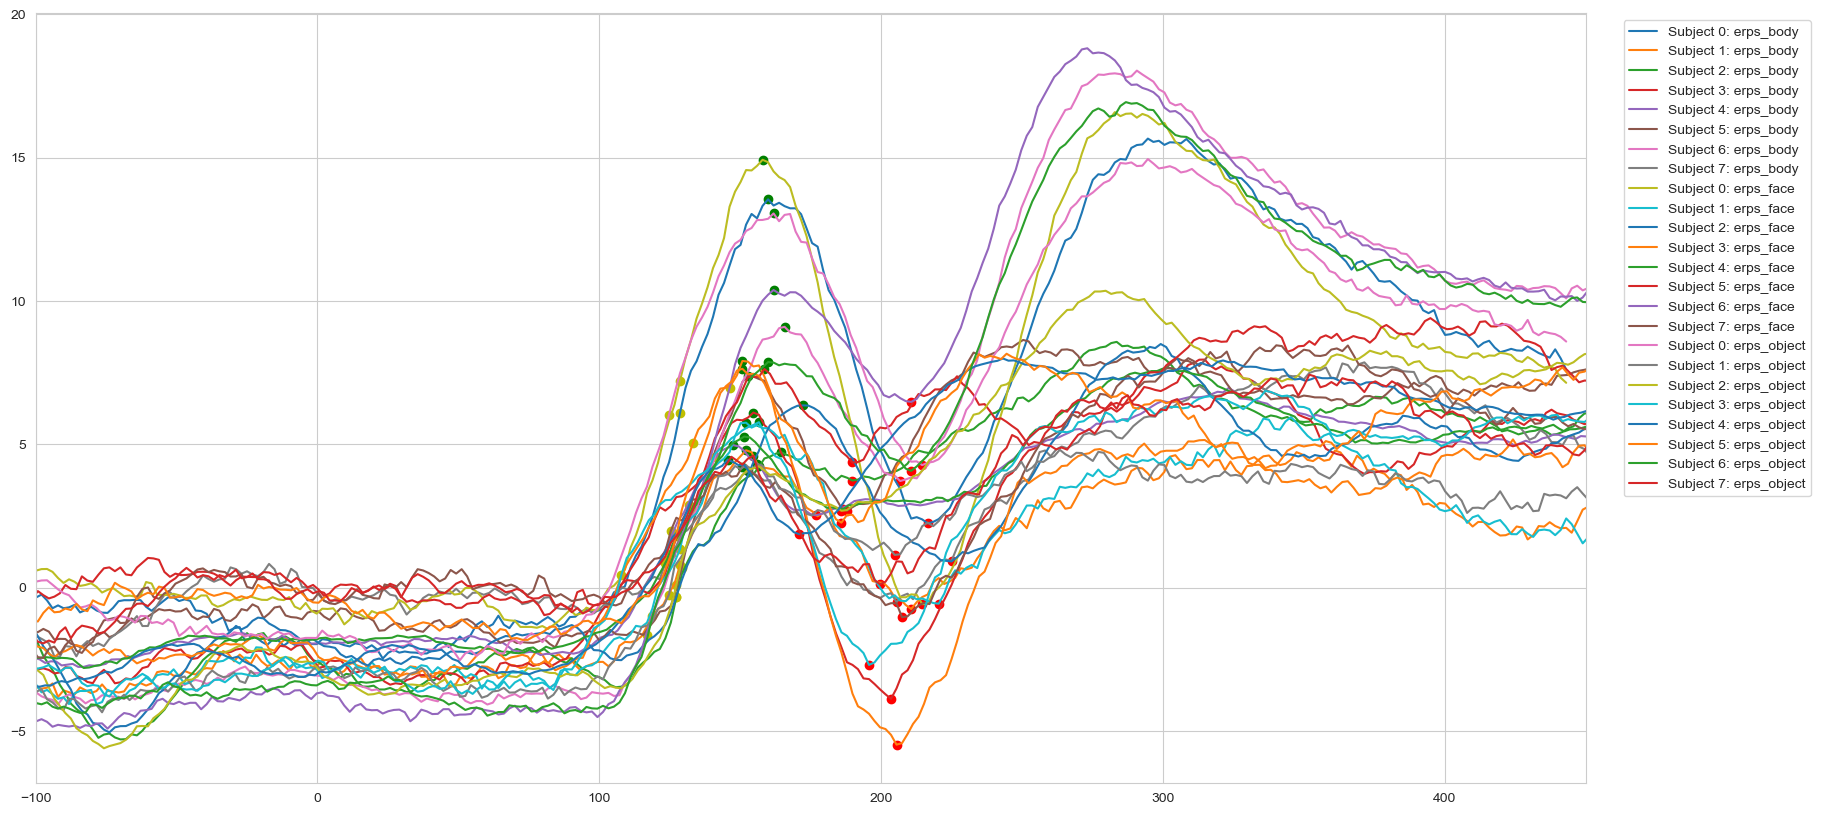

In [186]:
# Plot results
plt.figure(figsize=(20,10))
for key in ch_keys:
    for participant in range(participant_count):
        df4 = df_cleaned[df_cleaned['subject'] == participant] # select participant
        plt.scatter(df4.subj_time, df4[key+'_min'], c='r')
        plt.scatter(df4.subj_time, df4[key+'_max'], c='g')
        plt.scatter(df4.subj_time, df4[key+'_grads_extrema_key_value'], c='y')
        line, = plt.plot(df4.subj_time, df4[key])
        line.set_label(f"Subject {participant}: {key}")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xlim([-100, 450])
plt.show()

In [180]:
df_clean_erps = df_cleaned[all_keys + ["subject"]].melt(id_vars=["subject","subj_time"])

<AxesSubplot:xlabel='subj_time', ylabel='value'>

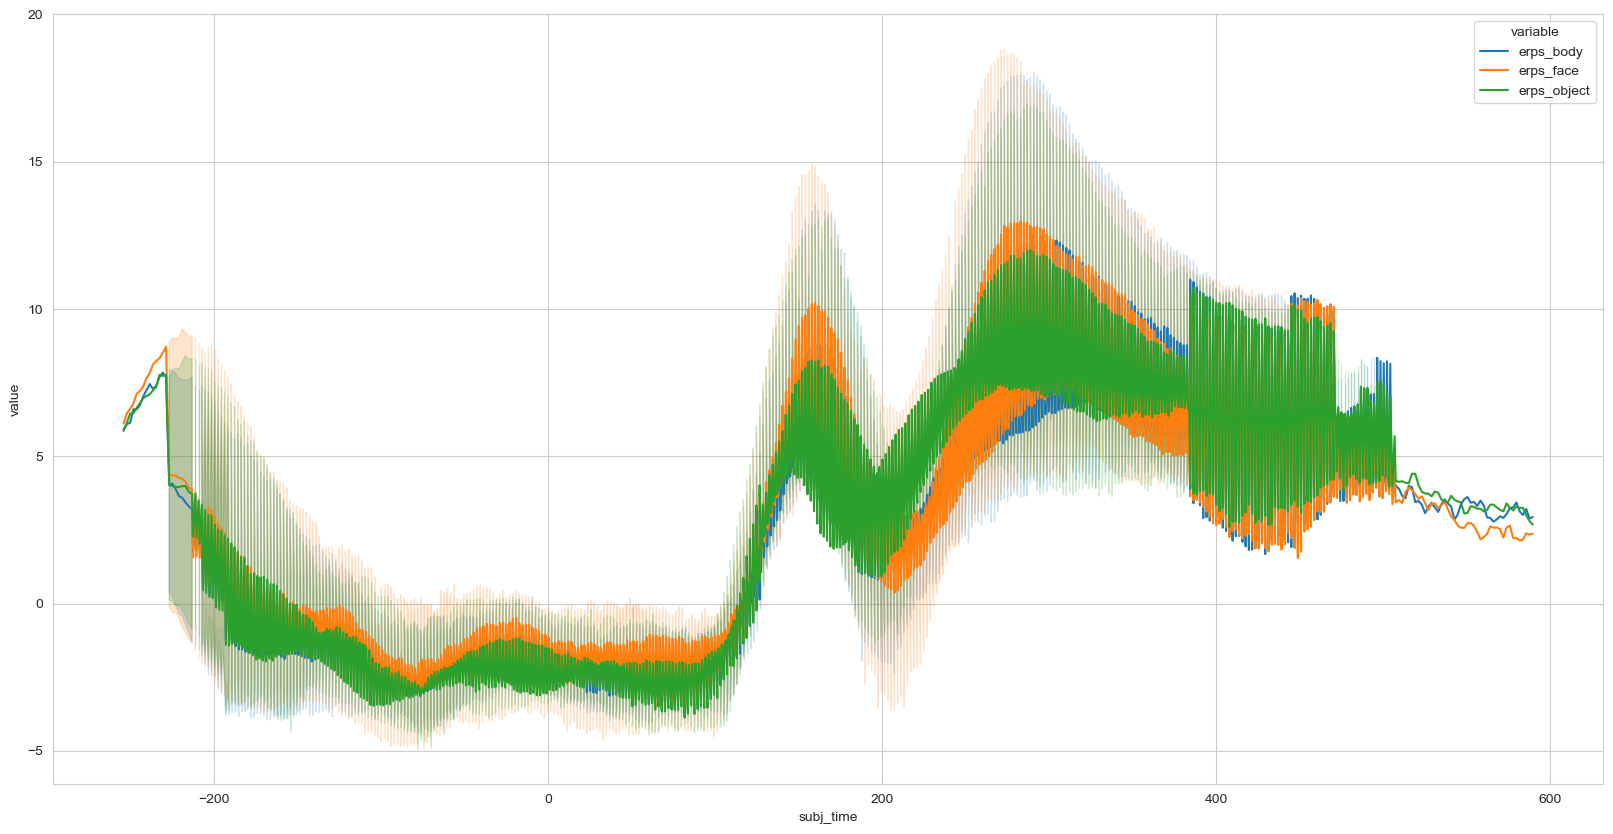

In [183]:
fig, ax = plt.subplots(nrows=1, figsize=(20, 10))
# time_window = df.loc[df['subject'] == 1, 'sub_time']
# time_window
sns.lineplot(data= df_clean_erps, x='subj_time', y='value', hue='variable', ax  =ax)

ERROR: Subject 0, key erps_body has 0 minimums and 1 maximums
Subject 1, key erps_body has minimum -0.7455092668533325 and maximum 4.79033088684082
Subject 2, key erps_body has minimum 3.7351179122924805 and maximum 4.731099605560303
Subject 3, key erps_body has minimum -3.881314516067505 and maximum 6.104855537414551
ERROR: Subject 4, key erps_body has 1 minimums and 2 maximums
Subject 5, key erps_body has minimum 2.687896251678467 and maximum 7.39567756652832
Subject 6, key erps_body has minimum 3.719270944595337 and maximum 9.096206665039062
Subject 7, key erps_body has minimum -0.5057152509689331 and maximum 4.0622687339782715
Subject 0, key erps_face has minimum -1.4442641735076904 and maximum -0.010012678802013397
Subject 1, key erps_face has minimum -0.5618327260017395 and maximum 5.753466606140137
Subject 2, key erps_face has minimum 0.9126566648483276 and maximum 6.3574323654174805
Subject 3, key erps_face has minimum -5.477518558502197 and maximum 7.905889511108398
ERROR: Sub

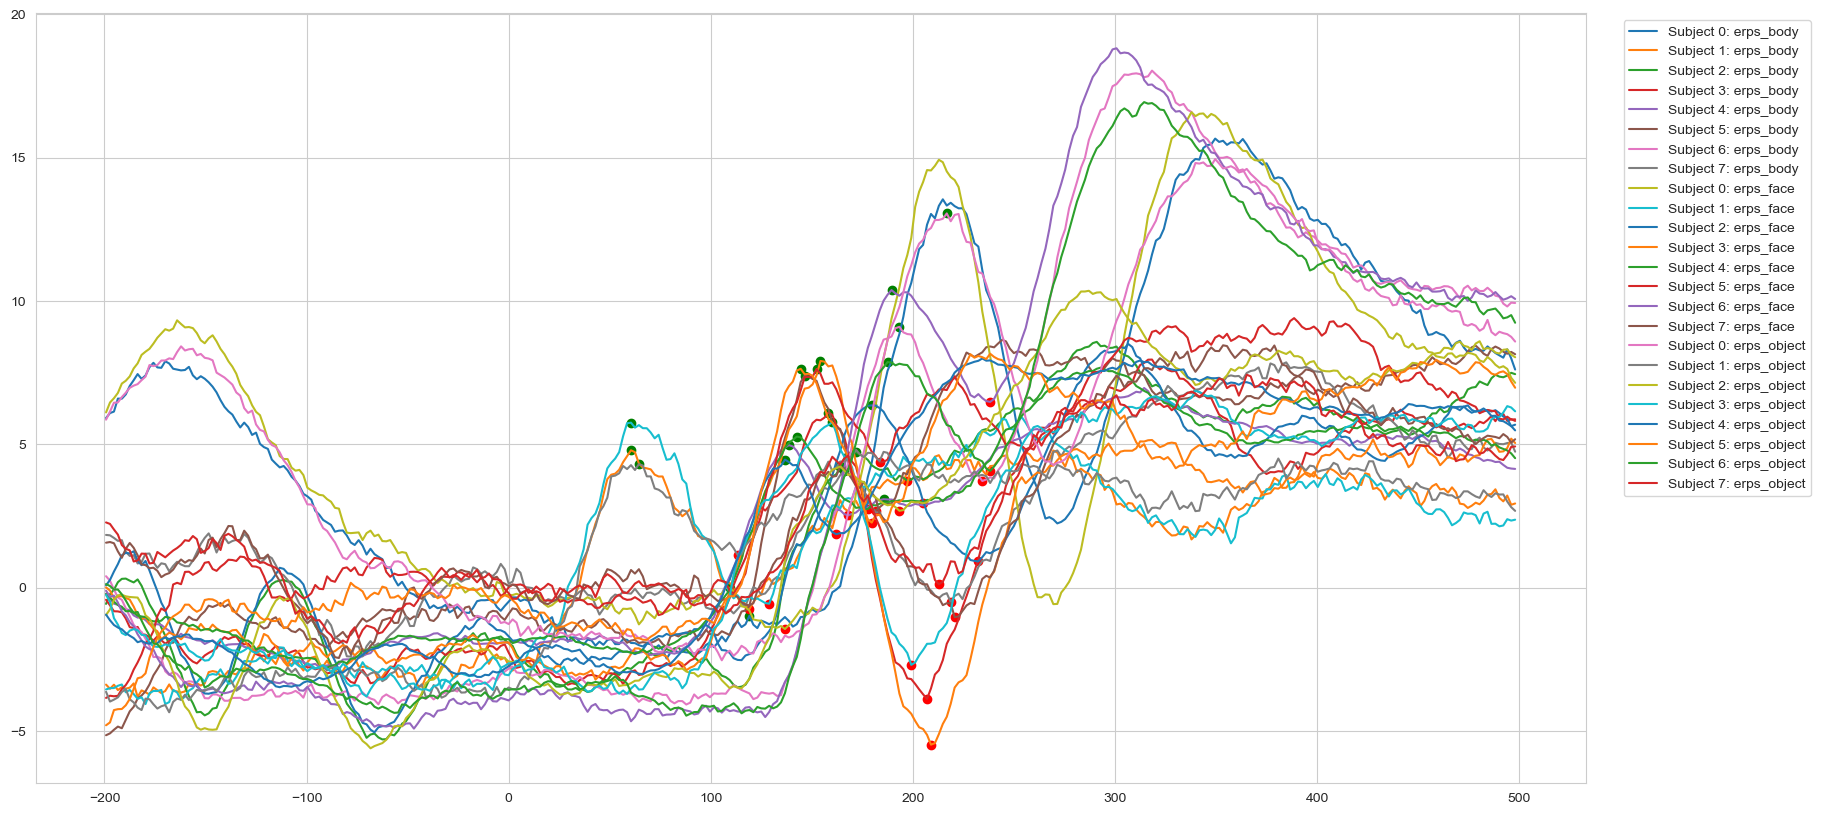

subject          key       min        max
0        1    erps_body -0.745509   4.790331
1        2    erps_body  3.735118   4.731100
2        3    erps_body -3.881315   6.104856
3        5    erps_body  2.687896   7.395678
4        6    erps_body  3.719271   9.096207
5        7    erps_body -0.505715   4.062269
6        0    erps_face -1.444264  -0.010013
7        1    erps_face -0.561833   5.753467
8        2    erps_face  0.912657   6.357432
9        3    erps_face -5.477519   7.905890
10       5    erps_face  4.364587   7.625519
11       6    erps_face  6.478173  10.379767
12       7    erps_face -1.031791   4.223801
13       1  erps_object  1.141222   4.307212
14       2  erps_object  2.679305   4.229972
15       3  erps_object -2.695131   5.770120
16       4  erps_object  1.861107   4.465773
17       5  erps_object  2.267371   7.632042
18       6  erps_object  4.071857   7.867554
19       7  erps_object  0.116071   4.608160

min       max
key                            
erps_body    0.834958  6.030073
erps_face    0.462859  6.033695
erps_object  1.348829  5.554405

In [168]:
window_length = 100 # length of the time window in milliseconds after the steepest ascent to look for the max and then min
df_min_max = pd.DataFrame(columns=['subject', 'key', 'min', 'max'])
plt.figure(figsize=(20,10))
for key in ch_keys:
    for participant in range(participant_count):
        ## Step 1: find the local time frame
        df4 = df3[(df3['subject'] == participant) & # Select the participant
                  (df3['subj_time'] > global_time_window_start) & (df3['subj_time'] < global_time_window_end)] # Select the global time window to search in
        df4.reset_index(inplace=True)

        # Get participant absolute maxima
        absolute_max_time = df4.iloc[np.array([df4[key + '_grads_extrema'].idxmax()])]['subj_time'].iloc[0]
        local_time_window_start = absolute_max_time
        local_time_window_end = absolute_max_time + window_length

        ## Step 2: find the min + max with the seleted window
        # Define the time window to look in for minima and maxima based on the grad maxima
        df4 = df3[(df3['subject'] == participant) & # Select the participant
                  (df3['subj_time'] > local_time_window_start) & (df3['subj_time'] < local_time_window_end)] # Select the time window to look in

        # Get participant absolute minima and maxima within the selected time frame (also the count)
        min = df4[key + '_min'].min()
        max = df4[key + '_max'].min()
        min_count = df4[key + '_min'].count()
        max_count = df4[key + '_max'].count()

        ## Step 3: If all goes right, add the min + max to the resulting data frame
        if min_count == 1 and max_count == 1:
            # If everything is good, this should give EXACTLY one min and one max; so this can be added to the overall array for aggregation
            print(f"Subject {participant}, key {key} has minimum {min} and maximum {max}")
            d = {'subject': [participant], 'key': [key], 'min': [min], 'max': [max]}
            df_min_max = pd.concat([df_min_max, pd.DataFrame.from_dict(d)], ignore_index=True)
        else:
            # This will throw an error and NOT include the data, if too many maxs or mins are in the local time frame
            print(f"ERROR: Subject {participant}, key {key} has {min_count} minimums and {max_count} maximums")

        df4 = df3[df3['subject'] == participant] # select participant
        df4_points = df4[(df4['subj_time'] > local_time_window_start) & (df4['subj_time'] < local_time_window_end)] # select time window

        plt.scatter(df4_points.subj_time, df4_points [key+'_min'], c='r')
        plt.scatter(df4_points.subj_time, df4_points [key+'_max'], c='g')
        line, = plt.plot(df4.subj_time, df4[key])
        line.set_label(f"Subject {participant}: {key}")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

display(df_min_max, df_min_max.groupby(['key']).agg({'min': 'mean', 'max': 'mean'}))

In [90]:
#  calculate difference between positive and negative peaks
df_min_max['diff'] = df_min_max['max']-df_min_max['min']
df_min_max

subject          key       min        max       diff
0        0    erps_body  2.239992  13.544217  11.304225
1        1    erps_body -0.745509   4.790331   5.535840
2        2    erps_body  3.735118   4.731100   0.995982
3        3    erps_body -3.881315   6.104856   9.986170
4        5    erps_body  2.687896   7.395678   4.707781
5        6    erps_body  3.719271   9.096207   5.376936
6        7    erps_body -0.505715   4.062269   4.567984
7        0    erps_face -0.576012  14.922929  15.498941
8        1    erps_face -0.561833   5.753467   6.315299
9        2    erps_face  0.912657   6.357432   5.444776
10       3    erps_face -5.477519   7.905890  13.383408
11       5    erps_face  4.364587   7.625519   3.260932
12       6    erps_face  6.478173  10.379767   3.901594
13       7    erps_face -1.031791   4.223801   5.255591
14       0  erps_object  4.273242  13.051940   8.778697
15       1  erps_object  1.141222   4.307212   3.165991
16       2  erps_object  2.679305   4.229972   1.550667
17       3  erps_object -2.695131   5.770120   8.465251
18       4  erps_object  1.861107   4.465773   2.604666
19       5  erps_object  2.267371   7.632042   5.364671
20       6  erps_object  4.071857   7.867554   3.795697
21       7  erps_object  0.116071   4.608160   4.492090